# Análise comparativa de modelos

In [23]:
# import libraries

from IPython.display import display, Markdown
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import plotly.express as px

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import ShuffleSplit, GridSearchCV, KFold, cross_validate
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## 1. Obtenção de dados

In [24]:
df = pd.read_csv("../data/raw/Churn_Modelling.csv")
dictionary = pd.read_csv("../data/external/dictionary.csv")
df, dictionary

(      RowNumber  CustomerId    Surname  CreditScore Geography  Gender  Age  \
 0             1    15634602   Hargrave          619    France  Female   42   
 1             2    15647311       Hill          608     Spain  Female   41   
 2             3    15619304       Onio          502    France  Female   42   
 3             4    15701354       Boni          699    France  Female   39   
 4             5    15737888   Mitchell          850     Spain  Female   43   
 ...         ...         ...        ...          ...       ...     ...  ...   
 9995       9996    15606229   Obijiaku          771    France    Male   39   
 9996       9997    15569892  Johnstone          516    France    Male   35   
 9997       9998    15584532        Liu          709    France  Female   36   
 9998       9999    15682355  Sabbatini          772   Germany    Male   42   
 9999      10000    15628319     Walker          792    France  Female   28   
 
       Tenure    Balance  NumOfProducts  HasCrCard

## 2. Preparação de dados

In [25]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
dictionary = dictionary.drop(index=0)
df.isnull().sum().sum()
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [36]:
target_column = 'Exited'

nominal_columns = (
    dictionary
    .query("variavel in ['Geography', 'Gender'] and variavel != @target_column")
    .variavel
    .to_list()
)

rest_columns = (
    dictionary
    .query("variavel != ['Geography', 'Gender', @target_column]")
    .variavel
    .to_list()
)

X = df.drop(columns=[target_column], axis=1)
y = df[target_column]

In [37]:
X

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10
...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77
9997,709,France,Female,36,7,0.00,1,0,1,42085.58
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52


Intervalo interquartil (IQR) para identificar e remover outliers, entre Q3 e Q1, ccom fator adaptado para 1.4

In [43]:
q1 = df[rest_columns].quantile(0.25)
q3 = df[rest_columns].quantile(0.75)
iqr = q3 - q1

factor = 1.4

lower_bound = q1 - factor * iqr
upper_bound = q3 + factor * iqr

X = X[~((X <= lower_bound) | (X >= upper_bound)).any(axis=1)]
upper_bound, lower_bound


/tmp/ipykernel_18989/988001997.py:10: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  X = X[~((X <= lower_bound) | (X >= upper_bound)).any(axis=1)]


(CreditScore           905.600
 Age                    60.800
 Tenure                 12.600
 Balance            306346.176
 NumOfProducts           3.400
 HasCrCard               2.400
 IsActiveMember          2.400
 EstimatedSalary    287128.840
 dtype: float64,
 CreditScore           396.4000
 Age                    15.2000
 Tenure                 -2.6000
 Balance           -178701.9360
 NumOfProducts          -0.4000
 HasCrCard              -1.4000
 IsActiveMember         -1.4000
 EstimatedSalary    -86738.4825
 dtype: float64)

In [41]:
X
# 539

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10
...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77
9997,709,France,Female,36,7,0.00,1,0,1,42085.58
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52


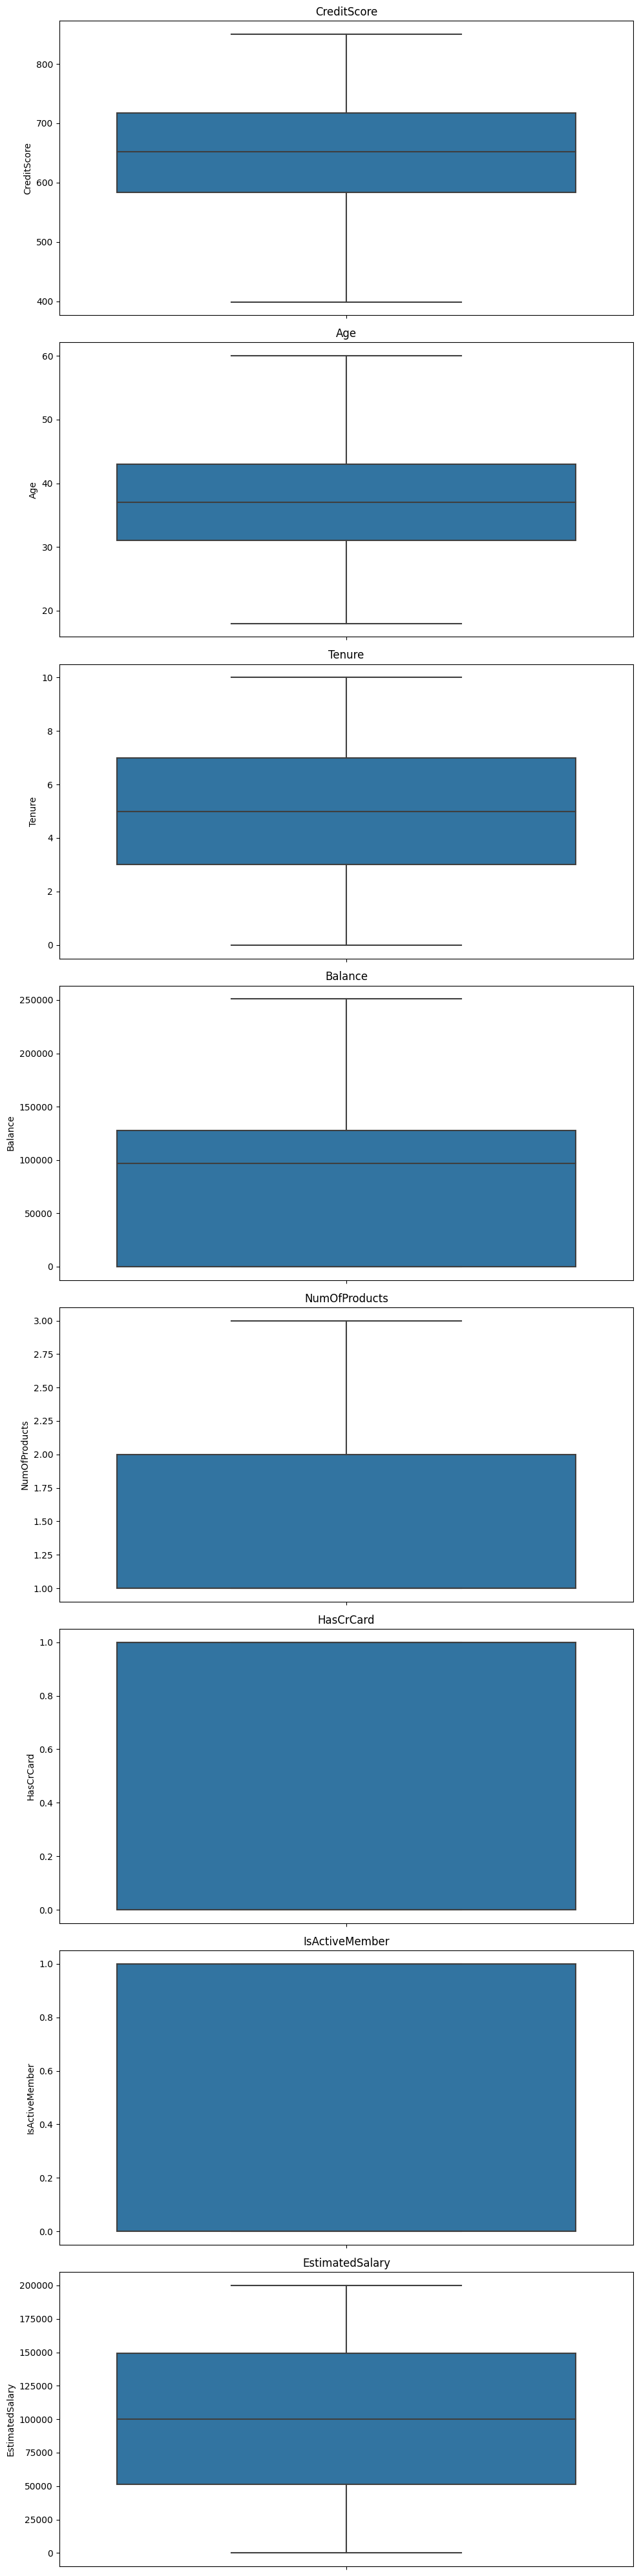

In [44]:
num_cols = len(rest_columns)
fig, axes = plt.subplots(num_cols, 1, figsize=(10, 5 * num_cols))

for i, col in enumerate(rest_columns):
    sns.boxplot(y=X[col], ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('')  

plt.tight_layout()

plt.show()

In [45]:
nominal_preprocessor = Pipeline([
    ('missing', SimpleImputer(strategy='most_frequent')), 
    ('encoding', OneHotEncoder(sparse_output=False)), 
    ('normalization', StandardScaler()) 
])
rest_preprocessor = Pipeline([
    ('missing', SimpleImputer(strategy='mean')), 
    ('normalization', StandardScaler()) 
])

preprocessor = ColumnTransformer([
    ('nominal', nominal_preprocessor, nominal_columns),
    ('rest', rest_preprocessor, rest_columns)
])

model = LogisticRegression()

In [46]:
X

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10
...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77
9997,709,France,Female,36,7,0.00,1,0,1,42085.58
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52


In [47]:
X = preprocessor.fit_transform(X)
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.995886,-0.577798,-0.573729,1.099295,-1.099295,-0.331689,0.534761,-1.045380,-1.223194,-0.940036,0.646377,0.997361,0.021505
1,-1.004131,-0.577798,1.742982,1.099295,-1.099295,-0.446352,0.416653,-1.391766,0.118805,-0.940036,-1.547085,0.997361,0.216123
2,0.995886,-0.577798,-0.573729,1.099295,-1.099295,-1.551281,0.534761,1.032932,1.333423,2.699694,0.646377,-1.002646,0.240273
3,0.995886,-0.577798,-0.573729,1.099295,-1.099295,0.502219,0.180438,-1.391766,-1.223194,0.879829,-1.547085,-1.002646,-0.109279
4,-1.004131,-0.577798,1.742982,1.099295,-1.099295,2.076222,0.652868,-1.045380,0.786586,-0.940036,0.646377,0.997361,-0.365599
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9456,0.995886,-0.577798,-0.573729,-0.909674,0.909674,1.252737,0.180438,-0.006224,-1.223194,0.879829,0.646377,-1.002646,-0.066787
9457,0.995886,-0.577798,-0.573729,-0.909674,0.909674,-1.405347,-0.291992,1.725703,-0.304546,-0.940036,0.646377,0.997361,0.027606
9458,0.995886,-0.577798,-0.573729,1.099295,-1.099295,0.606458,-0.173884,0.686547,-1.223194,-0.940036,-1.547085,0.997361,-1.008869
9459,-1.004131,1.730709,-0.573729,-0.909674,0.909674,1.263161,0.534761,-0.698995,-0.021028,0.879829,0.646377,-1.002646,-0.125590


## 3. Seleção de modelos

### 3.1 Resultados gerais

### 3.2 Persistência do modelo